This notebook is based on the [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview) competition on Kaggle.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Datasets

## holidays_events.csv

- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [51]:
holidays_events_df = pd.read_csv('datasets/holidays_events.csv', parse_dates=['date'])
holidays_events_df.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [52]:
holidays_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [53]:
holidays_events_df.nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

In [54]:
holidays_events_df.duplicated().sum()

np.int64(0)

## oil.csv

- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [55]:
oil_df = pd.read_csv('datasets/oil.csv', parse_dates=['date'])
print(oil_df.shape)
oil_df.head(10)

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [56]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [57]:
oil_df.nunique()

date          1218
dcoilwtico     998
dtype: int64

In [58]:
oil_df.duplicated().sum()

np.int64(0)

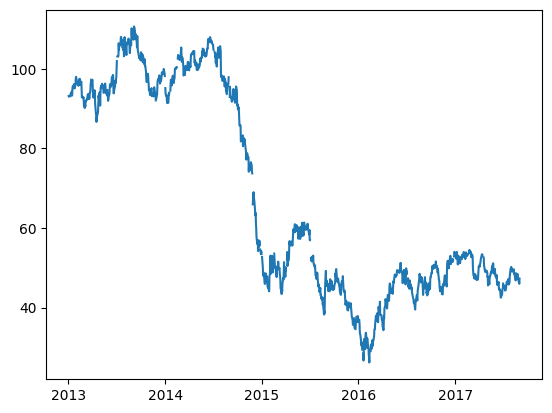

In [88]:
plt.plot(oil_df['date'], oil_df['dcoilwtico'])

## stores.csv


- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [59]:
stores_df = pd.read_csv('datasets/stores.csv')
print(stores_df.shape)
stores_df.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [60]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [61]:
stores_df.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

In [62]:
stores_df.duplicated().sum()

np.int64(0)

## train.csv

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [63]:
train_df = pd.read_csv('datasets/train.csv', parse_dates=['date'], index_col='id')
train_df

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 137.4+ MB


In [65]:
train_df.nunique()

date             1684
store_nbr          54
family             33
sales          379610
onpromotion       362
dtype: int64

In [66]:
train_df.duplicated().sum()

np.int64(0)

## test.csv

In [67]:
test_df = pd.read_csv('datasets/test.csv', parse_dates=['date'], index_col='id')
test_df

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1


In [68]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28512 entries, 3000888 to 3029399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         28512 non-null  datetime64[ns]
 1   store_nbr    28512 non-null  int64         
 2   family       28512 non-null  object        
 3   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.1+ MB


In [69]:
print('Number of unique values:')
print(test_df.nunique())
print('-')
print('Number of duplicated rows:', test_df.duplicated().sum())

Number of unique values:
date            16
store_nbr       54
family          33
onpromotion    212
dtype: int64
-
Number of duplicated rows: 0


## transactions

In [70]:
transactions_df = pd.read_csv('datasets/transactions.csv', parse_dates=['date'])
print(transactions_df.shape)
transactions_df.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [71]:
print(transactions_df.nunique())
transactions_df.info()

date            1682
store_nbr         54
transactions    4993
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


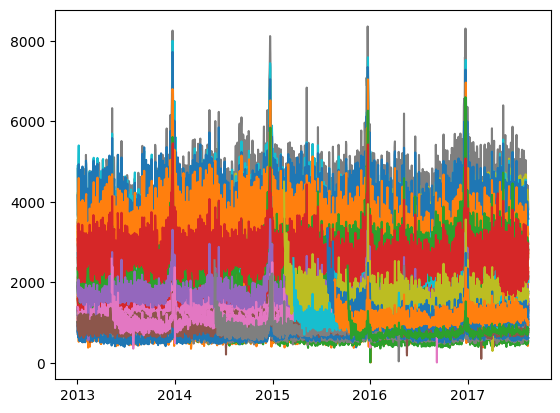

In [72]:
for store_nbr in transactions_df['store_nbr'].unique():
    i_store = transactions_df[transactions_df['store_nbr'] == store_nbr]
    plt.plot(i_store['date'], i_store['transactions'])

In [87]:
dayofweek_transactions = transactions_df.copy()
dayofweek_transactions['dayofweek'] = dayofweek_transactions['date'].dt.dayofweek # data['date'].dt.dayofweek returns 0 for Monday, 1 for Tuesday, ..., 6 for Sunday
dayofweek_transactions['year'] = dayofweek_transactions['date'].dt.year
dayofweek_transactions = dayofweek_transactions.groupby(['dayofweek', 'year']).agg({'transactions': 'mean'}).reset_index()
px.line(dayofweek_transactions, x='dayofweek', y='transactions', color='year', title='Average Transactions by Day of Week and Year', width=600).show()

## transactions + sales data

In [73]:
tr_tr_df = pd.merge(train_df.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions_df, how = "left")

In [79]:
px.scatter(tr_tr_df, x = "transactions", y = "sales", width=500)